# NN (L) Global Sustainable Equity time series forecasting using Prophet

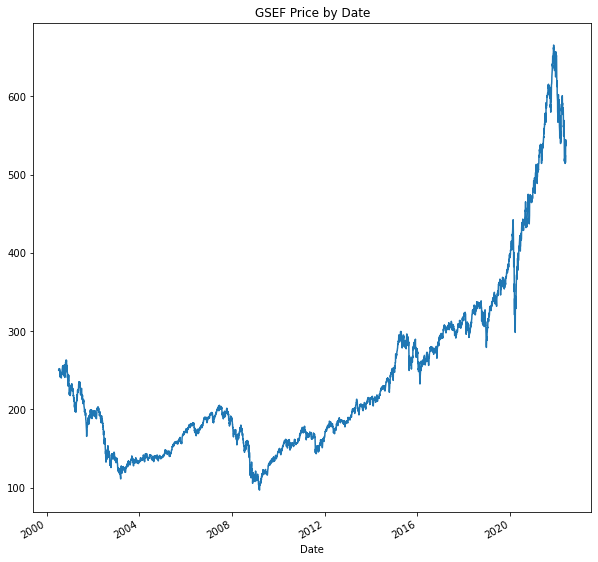

In [1]:
import timeit
start_time = timeit.default_timer()

# Import libraries
import time
import datetime as dt
import pandas as pd
import io
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_column',None)
tomorrow = (dt.date.today() + dt.timedelta(days=1)).isoformat() #get tomorrow in iso format as needed'''
url = pd.read_html("https://markets.ft.com/data/funds/tearsheet/historical?s=LU0119216553:EUR", header=0)
table = url[0]
gsef_latest = table[['Date', 'Close']]
gsef_latest_selected= gsef_latest.copy()

gsef_latest_selected['Date'] = gsef_latest_selected.loc[:,'Date'].str[-12:]
gsef_latest_selected['Date'] = pd.to_datetime(gsef_latest_selected['Date'], dayfirst=True)

gsef_historical= pd.read_csv('gsef_output/historical_gsef.csv', parse_dates=['Date'], dayfirst=True)

gsef = pd.concat([gsef_latest_selected, gsef_historical], ignore_index=True).sort_values(by="Date")

gsef = gsef.reset_index(drop=True)

gsef['pct_change']= (gsef["Close"].pct_change()*100).round(2)

gsef = gsef.drop_duplicates('Date')

gsef.to_csv('gsef_output/historical_gsef.csv', index=False)

gsef.plot(x= 'Date', y='Close', figsize=(10,10), title= 'GSEF Price by Date', legend=False)

historical_chart= 'gsef_output/gsef_historical.png'

import os
if os.path.exists(historical_chart):
  os.remove(historical_chart)
else:
  print("The historical chart didn't exist and it has been created.")

plt.savefig('gsef_output/gsef_historical.png')

plt.show()

In [2]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet

In [3]:
# Brief Description of our dataset
gsef.describe()

Close   pct_change
count  5531.00000  5530.000000
mean    238.53092     0.019817
std     117.00127     1.081842
min      96.81000    -9.930000
25%     157.42000    -0.470000
50%     195.41000     0.070000
75%     291.36500     0.550000
max     665.45000     9.540000

In [4]:
gsef.info() # Check whether the date is as object type or date type

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5531 entries, 0 to 5550
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        5531 non-null   datetime64[ns]
 1   Close       5531 non-null   float64       
 2   pct_change  5530 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 172.8 KB


In [5]:
gsef.head()

Date   Close  pct_change
0 2000-07-07  250.00         NaN
1 2000-07-10  250.00        0.00
2 2000-07-11  250.00        0.00
3 2000-07-12  249.61       -0.16
4 2000-07-13  249.80        0.08

In [6]:
class suppress_stdout_stderr(object):
    '''
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    '''
    def __init__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = (os.dup(1), os.dup(2))

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        os.close(self.null_fds[0])
        os.close(self.null_fds[1])

In [7]:
# Drop the columns
gsef = gsef.drop('pct_change', axis=1)
gsef.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)

gsef.head()

ds       y
0 2000-07-07  250.00
1 2000-07-10  250.00
2 2000-07-11  250.00
3 2000-07-12  249.61
4 2000-07-13  249.80

## Hyperparameter tuning

In [8]:
import itertools
import numpy as np
import pandas as pd
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

from dask.distributed import Client

client = Client()  # connect to the cluster

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(gsef)  # Fit model with given params
    df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='30 days', parallel="dask")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 41 forecasts with cutoffs between 2002-08-15 00:00:00 and 2022-05-02 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:52927' processes=4 threads=8, memory=15.39 GiB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 41 forecasts with cutoffs between 2002-08-15 00:00:00 and 2022-05-02 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:52927' processes=4 threads=8, memory=15.39 GiB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 41 forecasts with cutoffs between 2002-08-15 00:00:00 and 2022-05-02 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:52927' processes=4 threads=8, memory=15.39 GiB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with 

    changepoint_prior_scale  seasonality_prior_scale       rmse
0                     0.001                     0.01  48.178944
1                     0.001                     0.10  47.963036
2                     0.001                     1.00  48.351053
3                     0.001                    10.00  48.227037
4                     0.010                     0.01  30.047716
5                     0.010                     0.10  30.150018
6                     0.010                     1.00  30.189841
7                     0.010                    10.00  30.145181
8                     0.100                     0.01  28.371291
9                     0.100                     0.10  28.365456
10                    0.100                     1.00  28.359892
11                    0.100                    10.00  28.368554
12                    0.500                     0.01  28.345165
13                    0.500                     0.10  28.369180
14                    0.500             

In [12]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01}


In [18]:
changepoint_prior_scale= best_params['changepoint_prior_scale']
seasonality_prior_scale= best_params['seasonality_prior_scale']

## Initiating and training the Prophet algorithm

Steps for using Prophet:
- Make sure you replace closing price for y and date for ds.
- Fit that dataframe to Prophet in order to detect future patterns.
- Predict the upper and lower prices of the closing price.

In [19]:
m = Prophet(daily_seasonality=False, changepoint_prior_scale= changepoint_prior_scale, seasonality_prior_scale= seasonality_prior_scale)

m.fit(gsef)

In [20]:
# Create Future dates
future_prices = m.make_future_dataframe(periods=365)

# Predict Prices
forecast = m.predict(future_prices)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
5891 2023-05-28  675.534739  631.703934  724.972559
5892 2023-05-29  675.783946  632.623200  725.154233
5893 2023-05-30  676.539773  629.259566  722.287085
5894 2023-05-31  677.155027  633.555867  723.488524
5895 2023-06-01  677.567672  632.993867  721.706973

You can plot the forecast by calling the Prophet.plot method and passing in your forecast dataframe.

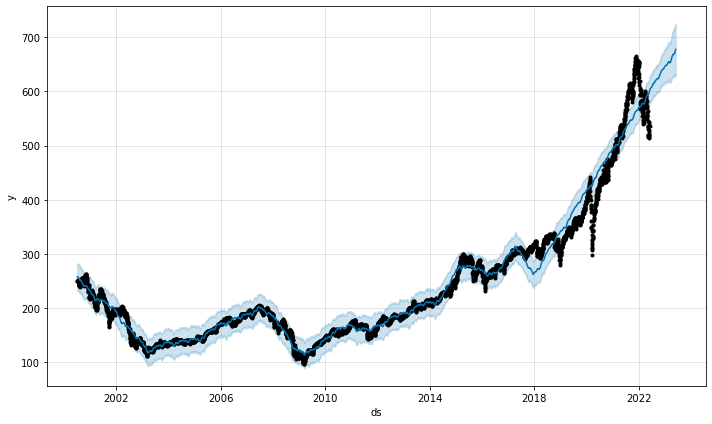

In [21]:
fig1 = m.plot(forecast)

If you want to see the forecast components, you can use the Prophet.plot_components method. By default you’ll see the trend, yearly seasonality, and weekly seasonality of the time series. If you include holidays, you’ll see those here, too.

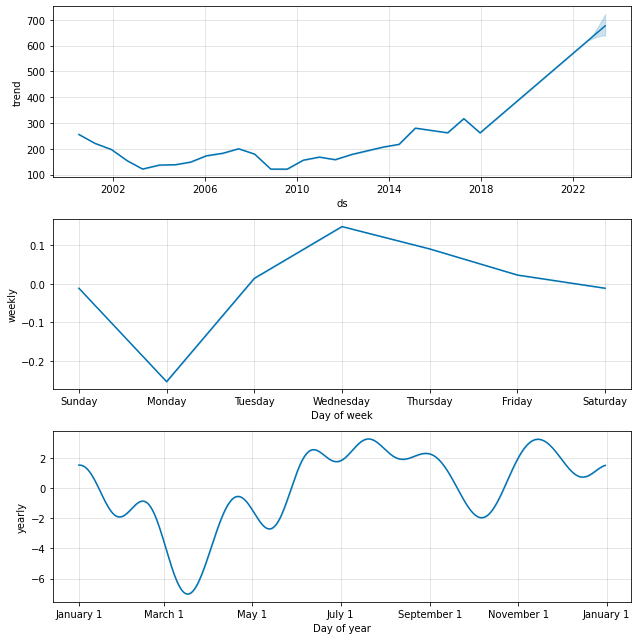

In [22]:
fig2 = m.plot_components(forecast)

An interactive figure of the forecast and components can be created with plotly. You will need to install plotly 4.0 or above separately, as it will not by default be installed with prophet. You will also need to install the notebook and ipywidgets packages.

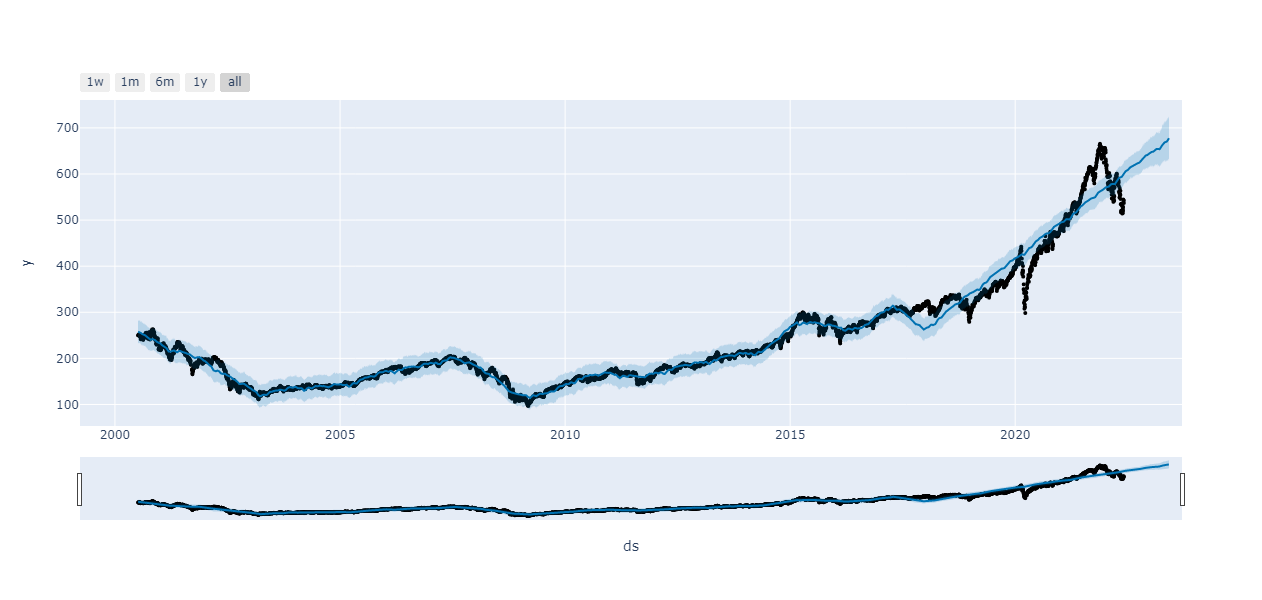

In [23]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

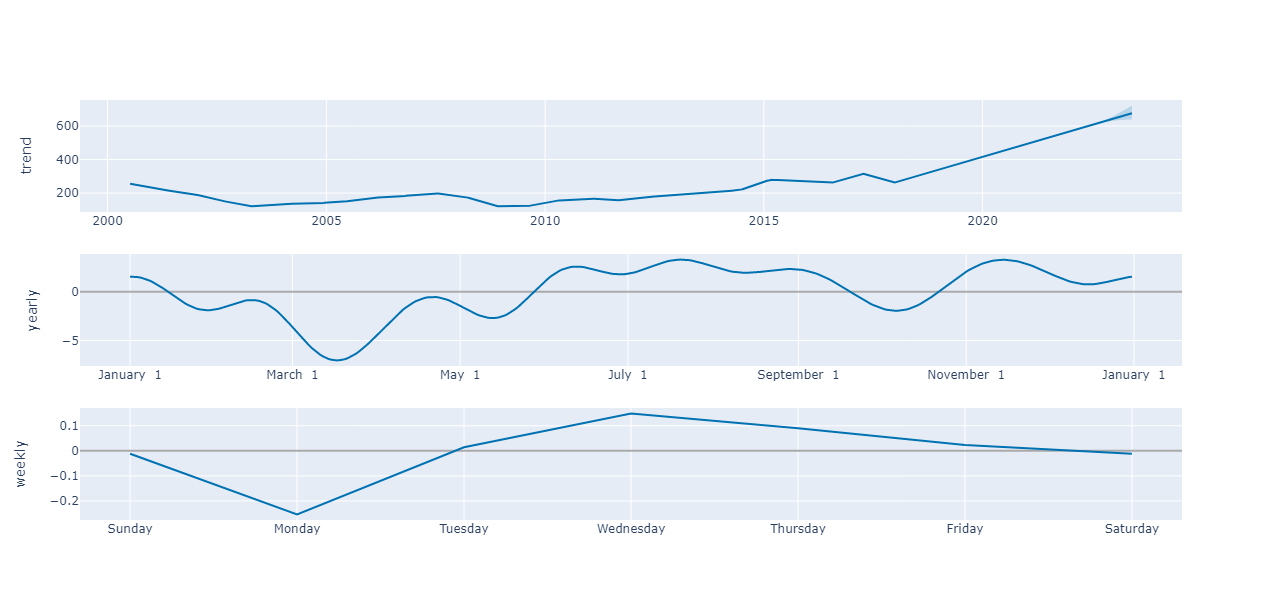

In [24]:
plot_components_plotly(m, forecast)

## Parallelized Cross validation

In [25]:
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='365 days', parallel="dask")

INFO:prophet:Making 39 forecasts with cutoffs between 2002-09-09 00:00:00 and 2021-06-01 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:52927' processes=4 threads=8, memory=15.39 GiB>


In [26]:
df_cv.head()

ds        yhat  yhat_lower  yhat_upper       y     cutoff
0 2002-09-10  138.583649  134.307786  142.490073  144.90 2002-09-09
1 2002-09-11  137.123960  132.681680  141.339040  146.47 2002-09-09
2 2002-09-12  136.273203  131.857109  140.527235  142.28 2002-09-09
3 2002-09-13  134.640315  129.898315  138.946626  140.68 2002-09-09
4 2002-09-16  131.604752  127.015721  136.183824  142.15 2002-09-09

In [27]:
df_p = performance_metrics(df_cv)
df_p.head()

horizon         mse       rmse        mae      mape     mdape     smape  \
0 37 days  535.177219  23.133898  15.452270  0.066418  0.045480  0.068183   
1 38 days  549.200071  23.435018  15.656362  0.067379  0.045653  0.069217   
2 39 days  558.417644  23.630862  15.822050  0.068231  0.045684  0.070131   
3 40 days  565.187289  23.773668  15.936419  0.068713  0.046105  0.070594   
4 41 days  581.788439  24.120291  16.106817  0.069110  0.046096  0.071004   

   coverage  
0  0.452986  
1  0.450309  
2  0.450698  
3  0.450661  
4  0.451980

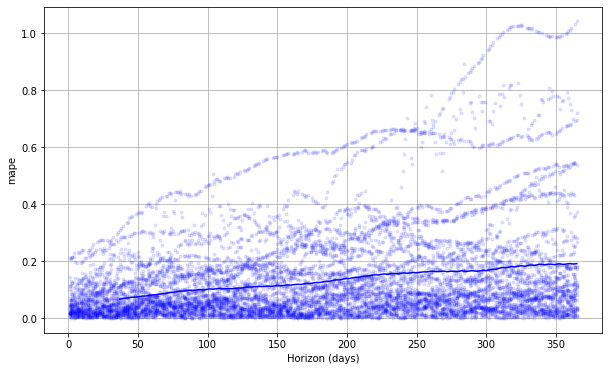

In [28]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

### Next:

1) Can more hyperparameter tuning can be done to significantly improve accuracy?
2) Check if Prophet's output has been suppressed 
3) If necessary, re-order the analysis in the notebook and automate the analysis wherever possible
4) Remove any unnecessary or low value steps from the analysis 
5) Document the notebook 
6) Create a .py script of the notebook 
7) Publish the project publicly on Github

In [29]:
# Calculate and print the time elapsed to run ETL process and the date and time of the latest run
time_elapsed = timeit.default_timer() - start_time

time_elapsed_seconds = int(time_elapsed % 60)

now = dt.datetime.now()

print("\n Success! Your GSEF forecast using Prophet has been updated in {} seconds on {}".format(time_elapsed_seconds, now.strftime("%Y-%m-%d %H:%M:%S")))


 Success! Your GSEF forecast using Prophet has been updated in 34 seconds on 2022-06-02 22:51:53
